# Préparation pour la classification mutliclass

In [1]:
import pandas as pd
from test import convertCatToNum, drop_rows_with_missing, normalize, encode_player_names, split_data
import numpy as np
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
import matplotlib as plt
import time

# on import toutes les données

df_atp_multi = pd.read_csv('all_matches_ATP_multi.csv')

In [2]:
df_atp_multi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37861 entries, 0 to 37860
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ATP         37861 non-null  int64  
 1   Court       37861 non-null  object 
 2   Surface     37861 non-null  object 
 3   Round       37861 non-null  object 
 4   Best of     37861 non-null  float64
 5   WRank       37861 non-null  int64  
 6   LRank       37861 non-null  int64  
 7   Comment     37861 non-null  object 
 8   PSW         37861 non-null  float64
 9   PSL         37861 non-null  float64
 10  B365W       37861 non-null  float64
 11  B365L       37861 non-null  float64
 12  Series      27456 non-null  float64
 13  y_multicat  37861 non-null  int64  
dtypes: float64(6), int64(4), object(4)
memory usage: 4.0+ MB


In [3]:
df_atp_multi.head(2)

,ATP,Court,Surface,Round,Best of,WRank,LRank,Comment,PSW,PSL,B365W,B365L,Series,y_multicat
0,3,Outdoor,Hard,1st Round,3.0,246,58,Completed,2.21,1.719,2.200,1.615,NaN,1
1,3,Outdoor,Hard,1st Round,3.0,43,6,Completed,3.25,1.385,2.875,1.364,NaN,1


In [4]:
cat_cols = ['Court','Surface','Round','Comment']
num_cols = ["PSW","PSL","Best of","B365W","B365L","Series","ATP","WRank","LRank"]

In [5]:
df_processed = convertCatToNum(df=df_atp_multi,cat_cols=cat_cols)
df = drop_rows_with_missing(df_processed,columns=["y_multicat","Series"])
df_final = normalize(df,num_cols)

 ===     Replace categorial variable     ===
 ===   Convert categorical to numerical  ===
 ===         drop missing values         ===
 ===            Normalize data           ===


In [6]:
df_final.head()

,ATP,Best of,WRank,LRank,PSW,PSL,B365W,B365L,Series,y_multicat,...,Round_1st Round,Round_2nd Round,Round_3rd Round,Round_4th Round,Round_Quarterfinals,Round_Round Robin,Round_Semifinals,Round_The Final,Comment_Completed,Comment_Retired
62,0.074627,1.0,0.014815,0.022584,0.006143,0.032836,0.007591,0.034903,1.000000,1,...,1,0,0,0,0,0,0,0,0,1
63,0.074627,1.0,0.005820,0.039674,0.000914,0.174931,0.001364,0.089909,1.000000,1,...,1,0,0,0,0,0,0,0,0,1
984,0.985075,0.0,0.001058,0.001424,0.009743,0.021002,0.015136,0.022402,0.714286,1,...,0,0,0,0,0,1,0,0,1,0
985,0.985075,0.0,0.003704,0.001221,0.008943,0.022752,0.013636,0.023902,0.714286,1,...,0,0,0,0,0,1,0,0,1,0
1056,0.074627,1.0,0.001058,0.005290,0.004114,0.046004,0.004545,0.054905,1.000000,1,...,0,0,0,0,1,0,0,0,0,1


In [7]:
X_train, X_test, y_train, y_test = split_data(df_final,target_column='y_multicat', test_size=0.2, random_state=42)

=== Splitting data into train and test sets ===
Data split completed.


In [8]:
X_train.shape

(21964, 25)

# Decision Tree

In [9]:
from sklearn.tree import DecisionTreeClassifier

# Define model
model = DecisionTreeClassifier()


# define search space
param_grid = {
    'max_depth': list(range(25, 100, 10)),
    'max_features': ['auto', 'sqrt', 'log2']
}

search = RandomizedSearchCV(model, param_grid, n_iter=10, cv=10, scoring='accuracy', n_jobs=-1, random_state=1)

# execute search
result = search.fit(X_train, y_train)

best_params_deci_tree_bin = result.best_params_
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: 0.2765435645394904
Best Hyperparameters: {'max_features': 'sqrt', 'max_depth': 35}


In [10]:
model = DecisionTreeClassifier(**best_params_deci_tree_bin)

start_time = time.time()

model.fit(X_train, y_train)

end_time = time.time()
DecisionTree_time = end_time - start_time

In [11]:
y_pred_test = model.predict(X_test)
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.19      0.21      0.20       961
           1       0.33      0.32      0.33      1840
           2       0.19      0.20      0.19       936
           3       0.34      0.33      0.33      1755

    accuracy                           0.28      5492
   macro avg       0.26      0.26      0.26      5492
weighted avg       0.29      0.28      0.28      5492



In [12]:
# On va garder le score d'accuracy pour pouvoir le comparer avec d'autres modèle
from sklearn.metrics import accuracy_score

DescisionTree_score_multi = accuracy_score(y_test, y_pred_test)
DescisionTree_score_multi

0.28168244719592134

# Xgboost

In [13]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Define the XGBoost model
model = xgb.XGBClassifier()

# Define the search space (parameter grid)
param_grid = {
    'n_estimators': np.arange(100, 1000, 100),  # Number of boosting rounds
    'max_depth': np.arange(3, 10),  # Maximum tree depth
    'learning_rate': [0.001,0.005,0.01, 0.1],  # Step size shrinkage used in update to prevent overfitting
    'subsample': [0.7, 0.8, 0.9, 1.0],  # Fraction of samples used for fitting the trees
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],  # Fraction of features used for fitting the trees
}

# Create a RandomizedSearchCV object
search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=10, cv=5, scoring='accuracy', n_jobs=-1, random_state=1)

# Execute the search
result = search.fit(X_train, y_train)

best_param_Xgboost_multi=result.best_params_

# Summarize the results
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: 0.3131030302804138
Best Hyperparameters: {'subsample': 0.7, 'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.001, 'colsample_bytree': 0.8}


In [14]:
model = xgb.XGBClassifier(**best_param_Xgboost_multi)

start_time = time.time()

model.fit(X_train, y_train)

end_time = time.time()
Xgboost_time = end_time - start_time

In [15]:
y_pred_test = model.predict(X_test)
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.36      0.01      0.01       961
           1       0.33      0.50      0.40      1840
           2       0.21      0.01      0.02       936
           3       0.31      0.47      0.38      1755

    accuracy                           0.32      5492
   macro avg       0.30      0.25      0.20      5492
weighted avg       0.31      0.32      0.26      5492



In [16]:
Xgboost_score_multi = accuracy_score(y_test, y_pred_test)
Xgboost_score_multi

0.3221048798252003

# CatBoost

In [17]:
from catboost import CatBoostClassifier
from sklearn.model_selection import RandomizedSearchCV

# Define the CatBoost model
model = CatBoostClassifier()

# Define the search space (parameter grid)
param_grid = {
    'iterations': [100, 200, 300],  # Number of boosting rounds
    'depth': [8,10,12],  # Maximum tree depth
    'learning_rate': [0.01, 0.1, 0.2, 0.3],  # Step size shrinkage used in update
    'colsample_bylevel': [0.7, 0.8, 0.9, 1.0],  # Fraction of features used for fitting the trees at each level
}

# Create a RandomizedSearchCV object
search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=10, cv=5, scoring='accuracy', n_jobs=-1, random_state=1)

# Execute the search
result = search.fit(X_train, y_train)

best_param_Xgboost_multi = result.best_params_

# Summarize the results
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

0:	learn: 1.3853222	total: 228ms	remaining: 22.5s
1:	learn: 1.3843275	total: 311ms	remaining: 15.3s
2:	learn: 1.3834581	total: 320ms	remaining: 10.4s
3:	learn: 1.3825401	total: 418ms	remaining: 10s
4:	learn: 1.3815922	total: 496ms	remaining: 9.42s
5:	learn: 1.3806543	total: 572ms	remaining: 8.96s
6:	learn: 1.3798006	total: 645ms	remaining: 8.57s
7:	learn: 1.3789350	total: 718ms	remaining: 8.25s
8:	learn: 1.3780727	total: 790ms	remaining: 7.99s
9:	learn: 1.3772660	total: 859ms	remaining: 7.73s
10:	learn: 1.3764371	total: 931ms	remaining: 7.53s
11:	learn: 1.3755592	total: 1.01s	remaining: 7.38s
12:	learn: 1.3747544	total: 1.08s	remaining: 7.24s
13:	learn: 1.3740913	total: 1.09s	remaining: 6.68s
14:	learn: 1.3733040	total: 1.16s	remaining: 6.58s
15:	learn: 1.3725122	total: 1.23s	remaining: 6.47s
16:	learn: 1.3717942	total: 1.31s	remaining: 6.38s
17:	learn: 1.3710841	total: 1.38s	remaining: 6.3s
18:	learn: 1.3703663	total: 1.46s	remaining: 6.21s
19:	learn: 1.3696445	total: 1.52s	remaining:

In [18]:
model = CatBoostClassifier(**best_param_Xgboost_multi)

start_time = time.time()

model.fit(X_train, y_train)

end_time = time.time()
CatBoost_time = end_time - start_time

0:	learn: 1.3853222	total: 74ms	remaining: 7.32s
1:	learn: 1.3843275	total: 144ms	remaining: 7.05s
2:	learn: 1.3834581	total: 151ms	remaining: 4.87s
3:	learn: 1.3825401	total: 225ms	remaining: 5.4s
4:	learn: 1.3815922	total: 300ms	remaining: 5.7s
5:	learn: 1.3806543	total: 384ms	remaining: 6.02s
6:	learn: 1.3798006	total: 466ms	remaining: 6.19s
7:	learn: 1.3789350	total: 543ms	remaining: 6.24s
8:	learn: 1.3780727	total: 612ms	remaining: 6.19s
9:	learn: 1.3772660	total: 682ms	remaining: 6.13s
10:	learn: 1.3764371	total: 752ms	remaining: 6.08s
11:	learn: 1.3755592	total: 824ms	remaining: 6.04s
12:	learn: 1.3747544	total: 894ms	remaining: 5.98s
13:	learn: 1.3740913	total: 898ms	remaining: 5.52s
14:	learn: 1.3733040	total: 966ms	remaining: 5.48s
15:	learn: 1.3725122	total: 1.04s	remaining: 5.44s
16:	learn: 1.3717942	total: 1.1s	remaining: 5.4s
17:	learn: 1.3710841	total: 1.18s	remaining: 5.35s
18:	learn: 1.3703663	total: 1.25s	remaining: 5.31s
19:	learn: 1.3696445	total: 1.31s	remaining: 5

In [19]:
y_pred_test = model.predict(X_test)
y_pred_test_prob = model.predict_proba(X_test)

print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       961
           1       0.34      0.48      0.40      1840
           2       0.67      0.00      0.00       936
           3       0.32      0.52      0.39      1755

    accuracy                           0.33      5492
   macro avg       0.33      0.25      0.20      5492
weighted avg       0.33      0.33      0.26      5492



In [20]:
catboost_score_multi = accuracy_score(y_test, y_pred_test)
catboost_score_multi

0.32665695557174074

# Logistique regression

In [21]:
from sklearn.linear_model import LogisticRegression

# Define model
model = LogisticRegression()

# define evaluation
# gkf = GroupKFold(n_splits=3) if not spec as cv= in the randomized search default is 5 fold cv

# define search space
param_grid = {
    'C' : np.logspace(0, 4, num=10),
    'penalty' : ['l1', 'l2'],
    'solver' : ['liblinear', 'sag']
}

search = RandomizedSearchCV(model, param_grid, n_iter=5, cv=10, scoring='accuracy', n_jobs=-1, random_state=1)

# execute search
result = search.fit(X_train, y_train)

best_params_logist_reg_multi = result.best_params_
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

c:\Users\mathi\anaconda3\envs\Keras\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
10 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\mathi\anaconda3\envs\Keras\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\mathi\anaconda3\envs\Keras\lib\site-packages\sklearn\linear_model\_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "c:\Users\mathi\anaconda3\envs\Keras\lib\site-packages\sklearn\linear_model\_logistic.py", line 54, 

Best Score: 0.3212534811089472
Best Hyperparameters: {'solver': 'sag', 'penalty': 'l2', 'C': 1291.5496650148827}


c:\Users\mathi\anaconda3\envs\Keras\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [22]:
model = LogisticRegression(**best_params_logist_reg_multi)

start_time = time.time()

model.fit(X_train,y_train)

end_time = time.time()
Logisti_reg_time = end_time - start_time

c:\Users\mathi\anaconda3\envs\Keras\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [23]:
y_pred_test = model.predict(X_test)
y_pred_test_prob = model.predict_proba(X_test)

print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.31      0.01      0.02       961
           1       0.33      0.49      0.39      1840
           2       0.25      0.01      0.03       936
           3       0.30      0.47      0.37      1755

    accuracy                           0.32      5492
   macro avg       0.30      0.25      0.20      5492
weighted avg       0.31      0.32      0.26      5492



In [24]:
logisti_reg_score_multi = accuracy_score(y_test, y_pred_test)
logisti_reg_score_multi

0.3179169701383831

# RandomForestClassifier

In [25]:
model = RandomForestClassifier()

# define search space
param_grid = {
    'max_depth': list(range(25, 100, 10)),
    'n_estimators': list(range(80, 200, 10))
}

search = RandomizedSearchCV(model, param_grid, n_iter=5, cv=10, scoring='accuracy', n_jobs=-1, random_state=1)

# execute search
result = search.fit(X_train, y_train)

best_params_random_multi = result.best_params_
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: 0.29502726851402766
Best Hyperparameters: {'n_estimators': 120, 'max_depth': 55}


In [26]:
model = RandomForestClassifier(**best_params_random_multi)

start_time = time.time()

model.fit(X_train, y_train)

end_time = time.time()
Random_time = end_time - start_time

In [27]:
y_pred_test = model.predict(X_test)
y_pred_test_prob = model.predict_proba(X_test)
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.19      0.10      0.13       961
           1       0.34      0.43      0.38      1840
           2       0.19      0.10      0.13       936
           3       0.33      0.40      0.36      1755

    accuracy                           0.31      5492
   macro avg       0.26      0.26      0.25      5492
weighted avg       0.28      0.31      0.29      5492



In [28]:
random_score_multi = accuracy_score(y_test, y_pred_test)
random_score_multi

0.3057174071376548

# MPLClassifier

In [29]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

mlp = MLPClassifier()
# Couche de sortie multiclasse 
# donc la fonction d’activation des neurones de la couche de sortie est 'Softmax'
mlp.out_activation_ = 'Softmax'
mlp.n_outputs_ = 1

param_grid = {
    'hidden_layer_sizes': [(30, 20, 15, 25),(50, 40, 30,20)],
    'activation':['relu', 'tanh', 'logistic'],
    'solver':  ['adam', 'lbfgs', 'sgd'],
}

grid_search = GridSearchCV(mlp, param_grid, n_jobs=-1, cv=3)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=MLPClassifier(), n_jobs=-1,
             param_grid={'activation': ['relu', 'tanh', 'logistic'],
                         'hidden_layer_sizes': [(30, 20, 15, 25),
                                                (50, 40, 30, 20)],
                         'solver': ['adam', 'lbfgs', 'sgd']})

In [30]:
best_params_mlp_multi = grid_search.best_params_
# meilleur parametre
print(f'Best parameters found : {best_params_mlp_multi}')

Best parameters found : {'activation': 'tanh', 'hidden_layer_sizes': (30, 20, 15, 25), 'solver': 'sgd'}


In [31]:
best_mlp = MLPClassifier(**best_params_mlp_multi)

start_time = time.time()

best_mlp.fit(X_train, y_train)

end_time = time.time()
mlp_time = end_time - start_time

In [32]:
y_pred_test = best_mlp.predict(X_test)
y_pred_test_prob = best_mlp.predict_proba(X_test)
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       961
           1       0.33      0.59      0.42      1840
           2       0.00      0.00      0.00       936
           3       0.30      0.38      0.34      1755

    accuracy                           0.32      5492
   macro avg       0.16      0.24      0.19      5492
weighted avg       0.21      0.32      0.25      5492



c:\Users\mathi\anaconda3\envs\Keras\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mathi\anaconda3\envs\Keras\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mathi\anaconda3\envs\Keras\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [33]:
mlp_multi = accuracy_score(y_test, y_pred_test)
mlp_multi

0.3199198834668609

# Comparaison modèles multiclass

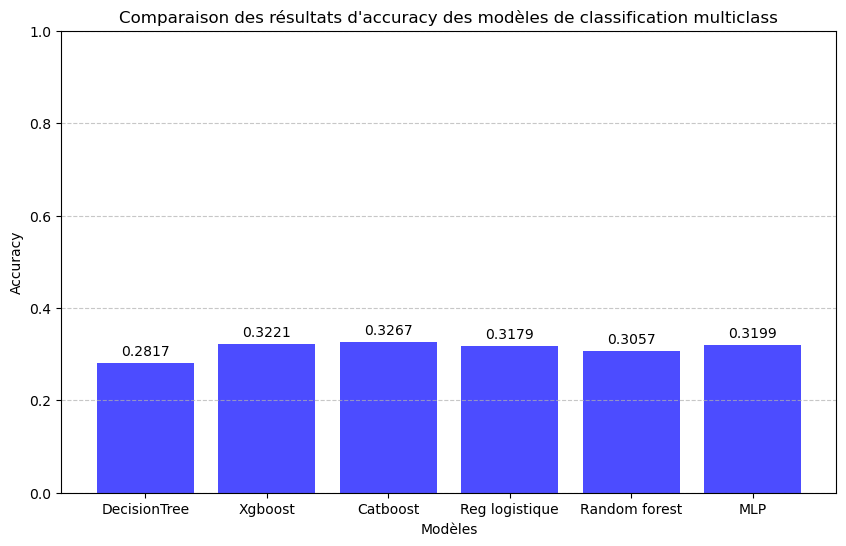

In [34]:
import matplotlib.pyplot as plt
import numpy as np

# Scores d'accuracy des différents modèles
accuracy_scores = [DescisionTree_score_multi, Xgboost_score_multi, catboost_score_multi, logisti_reg_score_multi, random_score_multi, mlp_multi] 

# Noms des modèles correspondants
model_names = ['DecisionTree', 'Xgboost', 'Catboost', 'Reg logistique', 'Random forest', 'MLP'] 

# Création de l'histogramme
plt.figure(figsize=(10, 6))
plt.bar(model_names, accuracy_scores, color='blue', alpha=0.7)
plt.xlabel('Modèles')
plt.ylabel('Accuracy')
plt.title('Comparaison des résultats d\'accuracy des modèles de classification multiclass')
plt.ylim(0, 1)  # Assurez-vous que l'axe y va de 0 à 1 pour l'accuracy
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Affichage des scores sur chaque barre
for i, v in enumerate(accuracy_scores):
    plt.text(i, v + 0.01, f'{v:.4f}', ha='center', va='bottom')

# Affichage de l'histogramme
plt.show()

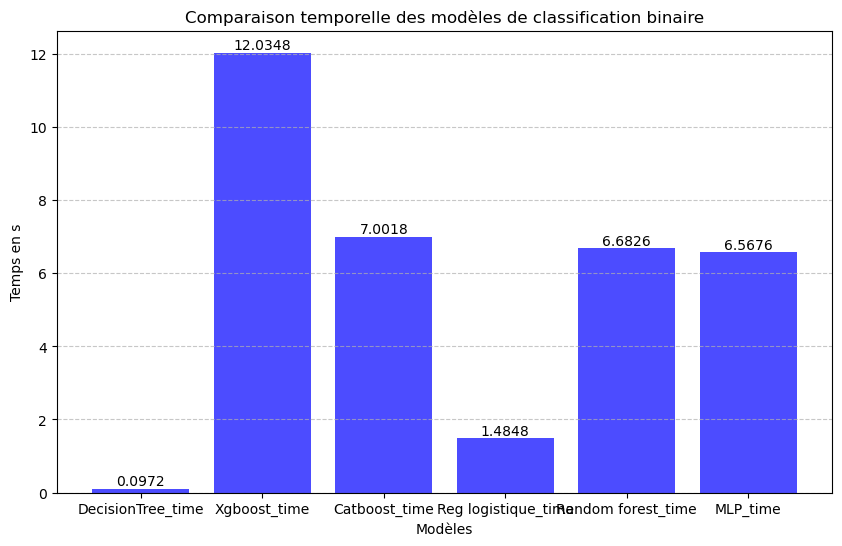

In [35]:
Temps = [DecisionTree_time, Xgboost_time, CatBoost_time, Logisti_reg_time, Random_time, mlp_time] 

# Noms des modèles correspondants
model_names = ['DecisionTree_time', 'Xgboost_time', 'Catboost_time', 'Reg logistique_time', 'Random forest_time', 'MLP_time'] 

# Création de l'histogramme
plt.figure(figsize=(10, 6))
plt.bar(model_names, Temps, color='blue', alpha=0.7)
plt.xlabel('Modèles')
plt.ylabel('Temps en s')
plt.title('Comparaison temporelle des modèles de classification binaire')
plt.grid(axis='y', linestyle='--', alpha=0.7)

for i, v in enumerate(Temps):
    plt.text(i, v + 0.01, f'{v:.4f}', ha='center', va='bottom')

# Affichage de l'histogramme
plt.show()